In [1]:
import pickle
from pathlib import Path

bolus_path = Path('/Volumes/TOSHIBA EXT/Animal Data/Bolus/bolus_features_by_mouse_ALL.pkl')
scan_names_path = Path('/Volumes/TOSHIBA EXT/Animal Data/Bolus/scan_names_by_mouse_ALL.pkl')

with open(bolus_path, 'rb') as f:
    bolus_features_by_mouse = pickle.load(f)
with open(scan_names_path, 'rb') as f:
    scan_names_by_mouse = pickle.load(f)

In [2]:
mouse_names = [names[0][:4] for names in scan_names_by_mouse]

In [3]:
import numpy as np

len(bolus_features_by_mouse), len(mouse_names) # Number of mice

(40, 40)

In [4]:
import yaml
import pandas as pd

yaml_path = Path('bolus-organization.yml')
data_organization = yaml.safe_load(yaml_path.read_text())

In [5]:
df = pd.DataFrame(columns=['mouse', 'day', 'radiomics-features', 'group', 'responder'])
for i, mouse in enumerate(mouse_names):
    for j in range(len(bolus_features_by_mouse[i])):
        bolus_features = bolus_features_by_mouse[i][j]
        group = data_organization[mouse]
        responder = group == 'LSAV'
        df = pd.concat((df, pd.DataFrame({'mouse': [mouse], 'day': [j], 'radiomics-features': [bolus_features], 
                                          'group': [group], 'responder': [responder]})), ignore_index=True)

In [6]:
features = list(df.loc[0, 'radiomics-features'][0].keys())
features[11]

'diagnostics_Image-original_Mean'

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_curve(data, window_size=5):
    """
    Smooth a curve using a moving average filter to remove noise
    
    Args:
        data: List or array of values to smooth
        window_size: Size of moving average window (default 5)
    Returns:
        Smoothed data array
    """
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='valid')

def remove_outliers(data, threshold=2, window_size=10):
    """
    Remove outliers from data using z-score method with sliding window
    
    Args:
        data: List or array of values to process
        threshold: Z-score threshold for outlier detection (default 2)
        window_size: Size of sliding window for local statistics (default 20)
    Returns:
        Data array with outliers replaced by local mean
    """
    data = np.array(data)
    cleaned_data = data.copy()
    
    # Use sliding window to detect and replace outliers
    for i in range(len(data)):
        # Calculate window boundaries
        window_start = max(0, i - window_size//2)
        window_end = min(len(data), i + window_size//2)
        
        # Get window excluding current point
        window = np.concatenate([data[window_start:i], data[i+1:window_end]])
        
        # Calculate z-score using local window statistics
        z_score = abs((data[i] - np.mean(window)) / np.std(window))
        
        # Replace outliers with local mean
        if z_score > threshold:
            cleaned_data[i] = np.mean(window)
            
    return cleaned_data

def find_steepest_ascent_end(data, window_size=5):
    # Calculate rolling gradients
    gradients = []
    for i in range(len(data)-window_size):
        gradient = (data[i+window_size] - data[i])/window_size
        gradients.append(gradient)
    
    # Find where gradient starts decreasing significantly
    peak_gradient_idx = np.argmax(gradients)
    threshold = np.max(gradients) * 0.01  # 50% of max gradient
    
    for i in range(peak_gradient_idx, len(gradients)):
        if gradients[i] < threshold:
            return i + (window_size)  # Return the index of the steepest ascent end
            
    return peak_gradient_idx + window_size

In [44]:
vals = df.loc[1, 'radiomics-features']

In [45]:
startIx = 0; endIx = 100
feature = 'diagnostics_Image-original_Mean'

bolus_feature_vals = []; molecular_feature_vals = []
for j in range(startIx, min(endIx, len(vals))):
    try:
        bolus_feature_vals.append(vals[j][feature])
    except KeyError:
        bolus_feature_vals.append(bolus_feature_vals[-1])
        
try:    
    smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
except ValueError:
    print("Skipping", feature)
cleaned_bolus = remove_outliers(smoothed_bolus_vals)

In [46]:
peak_idx = find_steepest_ascent_end(cleaned_bolus, window_size=5)


time_points = np.arange(len(cleaned_bolus[peak_idx:]))
bolus_log_values = np.log(cleaned_bolus[peak_idx:])

In [48]:
peak_idx

24

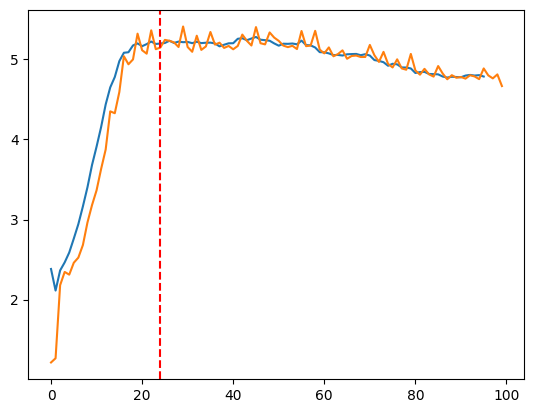

In [50]:
import matplotlib.pyplot as plt
plt.plot(cleaned_bolus)
plt.plot(bolus_feature_vals)

plt.axvline(x=peak_idx, color='r', linestyle='--', label='Peak')

In [171]:
from scipy.optimize import curve_fit
from math import exp

def bolus_lognormal(x, auc, mu, sigma, t0):
   curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
   return np.nan_to_num(curve_fit)

In [204]:
import matplotlib.pyplot as plt

startIx = 0; endIx = 350

lognormal_df = pd.DataFrame(columns=['mouse', 'auc', 'mu', 'sigma', 't0', 'mtt', 'tp', 'pe'])

# Calculate washout rate for each curve
for idx, row in df.iterrows():  
    
    featureIx = 11
    feature = features[featureIx]
    bolus_vals = df.loc[idx, 'radiomics-features']
    day = df.loc[idx, 'day']
    mouse = df.loc[idx, 'mouse']
    
    bolus_feature_vals = []
    for j in range(startIx, min(endIx, len(bolus_vals))):
        try:
            bolus_feature_vals.append(bolus_vals[j][feature])
        except KeyError:
            bolus_feature_vals.append(bolus_feature_vals[-1])
            
    
    # Remove outliers
    try:    
        smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
    except ValueError:
        # print("Skipping", feature)
        continue
    cleaned_bolus = remove_outliers(smoothed_bolus_vals)
    cleaned_bolus /= np.amax(cleaned_bolus)
    time_points = np.arange(len(cleaned_bolus))
    
    # Fit line to log-transformed values
    try:
        timeconst = 1
        popt, pcov = curve_fit(bolus_lognormal, time_points, cleaned_bolus, p0=(1.0,3.0,0.5,0.1),bounds=([0., 0., 0., -1.], [np.inf, np.inf, np.inf, 10.]),method='trf')#p0=(1.0,3.0,0.5,0.1) ,**kwargs
        auc = popt[0]; mu=popt[1]; sigma=popt[2]; t0=popt[3]; mtt=timeconst*np.exp(mu+sigma*sigma/2);
        tp = timeconst*exp(mu-sigma*sigma); wholecurve = bolus_lognormal(time_points, popt[0], popt[1], popt[2], popt[3]); pe = np.max(wholecurve);
        lognormal_df = pd.concat((lognormal_df, 
                                        pd.DataFrame({'mouse': [mouse],  
                                                    'day': [day],
                                                    'auc': [auc],
                                                    'mu': [mu],
                                                    'sigma': [sigma],
                                                    't0': [t0],
                                                    'mtt': [mtt],
                                                    'tp': [tp],
                                                    'pe': [pe],
                                                    'responder': [df.loc[idx, 'responder']],})),
                                        ignore_index=True)
    except Exception as e:
        print(e)
        print("SKIPPING")
    

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/3406950764.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lognormal_df = pd.concat((lognormal_df,
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  cu

Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid va

Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid va

Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid va

Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid va

Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2696483403.py:5: RuntimeWarning: invalid va

In [196]:
diff_lognormal_df = pd.DataFrame(columns=['mouse', 'auc', 'mu', 'sigma', 't0', 'mtt', 'tp', 'pe', 'responder'])

# Create a DataFrame for day differences
day_0_data = lognormal_df[lognormal_df['day'] == 0].copy()
day_1_data = lognormal_df[lognormal_df['day'] == 1].copy()

# Ensure we're comparing the same mice and contrast
comparison_cols = ['mouse']
diff_lognormal_df = day_1_data.merge(day_0_data, on=comparison_cols, suffixes=('_day1', '_day0'))

# Calculate differences for all numeric columns
numeric_cols = ['auc', 'mu', 'sigma', 't0', 'mtt', 'tp', 'pe']

for col in numeric_cols:
    diff_lognormal_df[f'{col}_diff'] = diff_lognormal_df[f'{col}_day1'] - diff_lognormal_df[f'{col}_day0']

# Keep only relevant columns
keep_cols = ['mouse', 'responder_day1'] + [f'{col}_diff' for col in numeric_cols]
diff_lognormal_df = diff_lognormal_df[keep_cols]

# Rename columns to be cleaner
diff_lognormal_df = diff_lognormal_df.rename(columns={'responder_day1': 'responder'})


In [199]:
diff_lognormal_df.shape, lognormal_df.shape

((30, 9), (70, 11))

In [53]:
import matplotlib.pyplot as plt
from tqdm import tqdm


startIx = 0; endIx = 350

# Create a new dataframe to store washout rates
stats_df = pd.DataFrame(columns=['mouse', 'day', 'feature', 'washout_rate', 'group', 'responder',
                                        'min', 'max', 'mean', 'median', 'std'])

# Calculate washout rate for each curve
for idx, row in tqdm(df.iterrows(), total=len(df)):  
    
    for featureIx in range(11, len(features)):
        feature = features[featureIx]
        bolus_vals = df.loc[idx, 'radiomics-features'] 

        bolus_feature_vals = []
        for j in range(startIx, min(endIx, len(bolus_vals))):
            try:
                bolus_feature_vals.append(bolus_vals[j][feature])
            except KeyError:
                bolus_feature_vals.append(bolus_feature_vals[-1])
                
        
        # Remove outliers
        try:    
            smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
        except ValueError:
            # print("Skipping", feature)
            continue
        cleaned_bolus = remove_outliers(smoothed_bolus_vals)
        
        # Find the peak index
        if featureIx == 11:
            peak_idx = find_steepest_ascent_end(cleaned_bolus, window_size=5)
        
        # Calculate slope of decay after peak (washout rate)
        # Using linear regression on log-transformed values
        bolus_log_values = cleaned_bolus[peak_idx:]
        time_points = np.arange(len(cleaned_bolus[peak_idx:]))
        
        # Fit line to log-transformed values
        # plt.plot(time_points, bolus_log_values)
        # plt.show()
        # break
        try:
            bolus_slope, _ = np.polyfit(time_points, bolus_log_values, 1)
        except:
            print(idx)
            # print("FEATURE", feature)
            continue
        
        # Calculate additional statistics
        min_bolus = np.min(cleaned_bolus)
        max_bolus = np.max(cleaned_bolus)
        mean_bolus = np.mean(cleaned_bolus)
        median_bolus = np.median(cleaned_bolus)
        std_bolus = np.std(cleaned_bolus)
        
        # Store results
        stats_df = pd.concat((stats_df, 
                                    pd.DataFrame({'mouse': [row['mouse']], 
                                                'day': [row['day']], 
                                                'feature': [feature],
                                                'washout_rate': [bolus_slope],
                                                'group': [row['group']],
                                                'responder': [row['responder']],
                                                'min': [min_bolus],
                                                'max': [max_bolus], 
                                                'mean': [mean_bolus],
                                                'median': [median_bolus],
                                                'std': [std_bolus]})),
                                    ignore_index=True)

  0%|          | 0/80 [00:00<?, ?it/s]/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/2997566560.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat((stats_df,
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/3875803424.py:41: RuntimeWarning: invalid value encountered in scalar divide
  z_score = abs((data[i] - np.mean(window)) / np.std(window))
 19%|█▉        | 15/80 [00:04<00:17,  3.68it/s]/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/3875803424.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = abs((data[i] - np.mean(window)) / np.std(window))
100%|██████████| 80/80 [00:22<00:00,  3.57it/s]


In [55]:
stats_df.head()

,mouse,day,feature,washout_rate,group,responder,min,max,mean,median,std
0,m904,0,diagnostics_Image-original_Mean,-5.295005e-03,LSAV,True,2.284774,5.174612,4.707569,4.824946,5.428806e-01
1,m904,0,diagnostics_Image-original_Minimum,0.000000e+00,LSAV,True,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,m904,0,diagnostics_Image-original_Maximum,1.156555e-03,LSAV,True,98.800000,208.800000,194.793791,197.700000,1.452619e+01
3,m904,0,diagnostics_Mask-original_VoxelNum,1.064999e-13,LSAV,True,52392.000000,52392.000000,52392.000000,52392.000000,7.275958e-12
4,m904,0,diagnostics_Mask-original_VolumeNum,2.751198e-18,LSAV,True,1.000000,1.000000,1.000000,1.000000,0.000000e+00


In [241]:
# Create a DataFrame for day differences
day_0_data = stats_df[stats_df['day'] == 0].copy()
day_1_data = stats_df[stats_df['day'] == 1].copy()

# Ensure we're comparing the same mice and features
comparison_cols = ['mouse', 'feature']
diff_df = day_1_data.merge(day_0_data, on=comparison_cols, suffixes=('_day1', '_day0'))

# Calculate differences for all numeric columns
numeric_cols = ['washout_rate', 'min', 'max', 'mean', 'median', 'std']

for col in numeric_cols:
    diff_df[f'{col}_diff'] = diff_df[f'{col}_day1'] - diff_df[f'{col}_day0']

# Keep only relevant columns
keep_cols = ['mouse', 'feature', 'group_day1', 'responder_day1'] + [f'{col}_diff' for col in numeric_cols]
diff_df = diff_df[keep_cols]

# Rename columns to be cleaner
diff_df = diff_df.rename(columns={'group_day1': 'group', 'responder_day1': 'responder'})


In [242]:
diff_df.head()

,mouse,feature,group,responder,washout_rate_diff,min_diff,max_diff,mean_diff,median_diff,std_diff
0,m904,diagnostics_Image-original_Mean,LSAV,True,-3.100545e-03,-0.171544,0.105172,-0.068428,-0.087169,5.182130e-02
1,m904,diagnostics_Image-original_Minimum,LSAV,True,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,m904,diagnostics_Image-original_Maximum,LSAV,True,-3.305717e-02,33.800000,-11.400000,-3.980686,-6.100000,-7.791900e+00
3,m904,diagnostics_Mask-original_VoxelNum,LSAV,True,-5.506793e-13,30544.000000,30544.000000,30544.000000,30544.000000,-7.275958e-12
4,m904,diagnostics_Mask-original_VolumeNum,LSAV,True,-1.121960e-17,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [243]:
# Calculate range overlap for each feature
overlap_scores = []

cols = ['washout_rate_diff',	'min_diff',	'max_diff',	'mean_diff',	'median_diff',	'min_diff',	'max_diff',	'std_diff']

for feature in diff_df['feature'].unique():
    # if 'Minimum' in feature or 'shape' in feature:
        # continue
    feature_data = diff_df[diff_df['feature'] == feature]
    responders = feature_data[feature_data['responder'] == True]
    non_responders = feature_data[feature_data['responder'] == False]
    
    # Calculate number of overlapping points
    min_col = ""
    min_overlap = 1000000
    for col in cols:
        responders[col] = responders[col].values
        non_responders[col] = non_responders[col].values
        
        resp_min, resp_max = np.min(responders[col]), np.max(responders[col])
        nonresp_min, nonresp_max = np.min(non_responders[col]), np.max(non_responders[col])
        overlap_range = (max(resp_min, nonresp_min), min(resp_max, nonresp_max))
        
        if overlap_range[0] > overlap_range[1]:
            overlap_count = 0
        else:
            overlap_count = (
                np.sum((responders[col].values >= overlap_range[0]) &
                       (responders[col].values <= overlap_range[1])) +
                np.sum((non_responders[col].values >= overlap_range[0]) &
                       (non_responders[col].values <= overlap_range[1]))
            ) + 1
        if overlap_count < min_overlap:
            min_overlap = overlap_count
            min_col = col
            min_overlap_range = overlap_range
        if overlap_count == 0:
            print(f"Feature: {feature}, Column: {col}, Overlap Count: {overlap_count}")
            
        if feature == "original_shape_Maximum3DDiameter" and col == "std_moecular_diff":
            print(f"Feature: {feature}, Column: {col}, Overlap Count: {overlap_count}")
            print(f"Overlap Range: {overlap_range}")
            print(f"Responders: {responders[col].values}")
            print(f"Non-responders: {non_responders[col].values}")
    overlap_scores.append((feature, min_col, min_overlap, min_overlap_range))


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/1228783335.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responders[col] = responders[col].values
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_54254/1228783335.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_responders[col] = non_responders[col].values


Feature with least overlap: original_firstorder_MeanAbsoluteDeviation
Feature with least overlap column: max_diff
Overlap score: 6


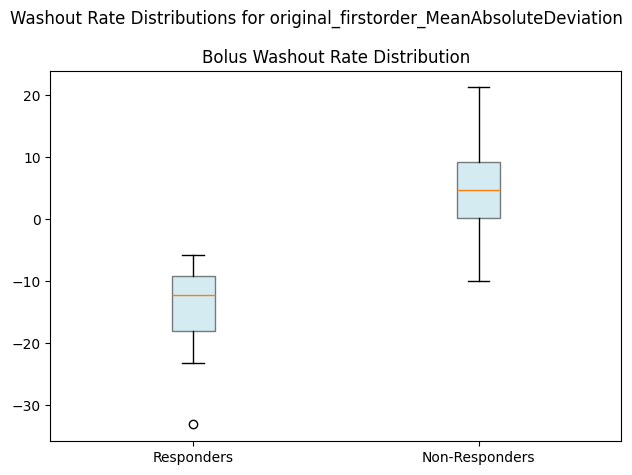

In [245]:
# Find feature with minimum overlap
best_feature = min(overlap_scores, key=lambda x: x[2])
print(f"Feature with least overlap: {best_feature[0]}")
print(f"Feature with least overlap column: {best_feature[1]}")
print(f"Overlap score: {best_feature[2]}")

# Plot the distributions for the best feature
feature_data = diff_df[diff_df['feature'] == best_feature[0]]
responders = feature_data[feature_data['responder'] == True]
non_responders = feature_data[feature_data['responder'] == False]

fig, ax = plt.subplots()

# Box plots for bolus
bp1 = ax.boxplot([responders[best_feature[1]], non_responders[best_feature[1]]], 
                  positions=[1, 2], patch_artist=True)
for box in bp1['boxes']:
    box.set(facecolor='lightblue', alpha=0.5)
ax.set_title('Bolus Washout Rate Distribution')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Responders', 'Non-Responders'])

plt.suptitle(f'Washout Rate Distributions for {best_feature[0]}')
plt.tight_layout()

Optimal threshold: -5.676
Accuracy: 0.950


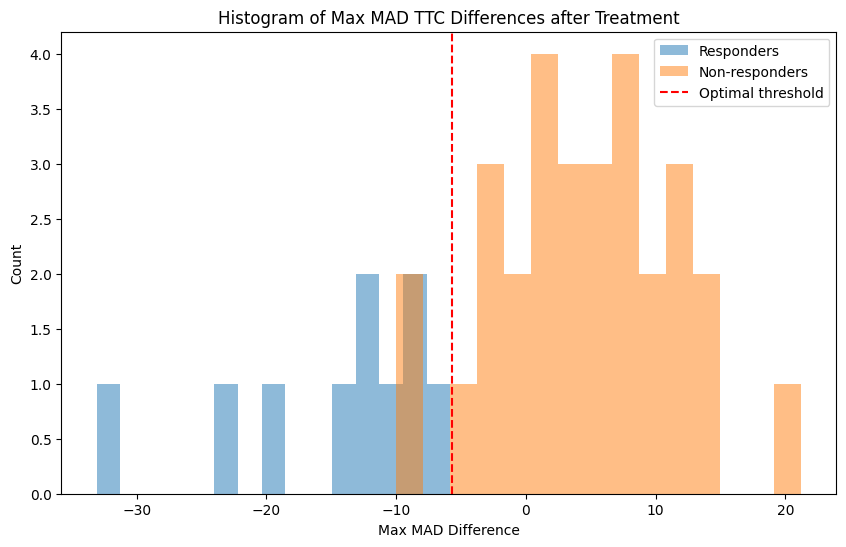

In [252]:
# Extract data for the specified feature
feature_data = diff_df[diff_df['feature'] == 'original_firstorder_MeanAbsoluteDeviation']

# Get molecular washout rate differences for responders and non-responders
responder_rates = feature_data[feature_data['responder']]['max_diff']
nonresponder_rates = feature_data[feature_data['responder'] == False]['max_diff']

# Try different thresholds and calculate accuracy
thresholds = np.linspace(min(feature_data['max_diff']), 
                        max(feature_data['max_diff']), 
                        100)
best_accuracy = 0
best_threshold = None

for threshold in thresholds:
    # Predict responders based on threshold
    predicted = feature_data['max_diff'] < threshold
    actual = feature_data['responder']
    
    # Calculate accuracy
    accuracy = np.mean(predicted == actual)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"Accuracy: {best_accuracy:.3f}")

# Plot the distributions with the threshold line
plt.figure(figsize=(10, 6))
plt.hist(responder_rates, alpha=0.5, label='Responders', bins=15)
plt.hist(nonresponder_rates, alpha=0.5, label='Non-responders', bins=15)
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Optimal threshold')
plt.xlabel('Max MAD Difference')
plt.ylabel('Count')
plt.title('Histogram of Max MAD TTC Differences after Treatment')
plt.legend()
plt.show()


# How many features perfectly split data? How many are perfect but one? P-value / how big of room for variability do we have? SEEMS OFF FOR NONZERO CASES

# PCA-SVM, PCA-LDA, PCA-MLP

In [253]:
# Pivot the diff_df to create a new dataframe where each row is a mouse
# and columns are the features with their respective metrics
mouse_df = diff_df.pivot(index=['mouse', 'group', 'responder'], 
                        columns='feature',
                        values=['washout_rate_diff', 'min_diff', 'max_diff', 'mean_diff', 'median_diff', 'std_diff'])


# Flatten the multi-level column names
mouse_df.columns = [f"{col[0]}_{col[1]}" for col in mouse_df.columns]

# Reset index to make mouse, group and responder regular columns
mouse_df = mouse_df.reset_index()

In [254]:
# Filter out one LSAV row and three other rows
lsav_row = mouse_df[mouse_df['group'] == 'LSAV'].iloc[0]  # Select the first LSAV row
other_rows = mouse_df[mouse_df['group'] != 'LSAV'].iloc[:3]  # Select the first three non-LSAV rows

# Combine the remaining rows into train_df
train_df = mouse_df.drop(lsav_row.name).drop(other_rows.index)
test_df = pd.concat([lsav_row.to_frame().T, other_rows], ignore_index=True)

In [255]:
train_df.shape, test_df.shape, mouse_df.shape

((36, 675), (4, 675), (40, 675))

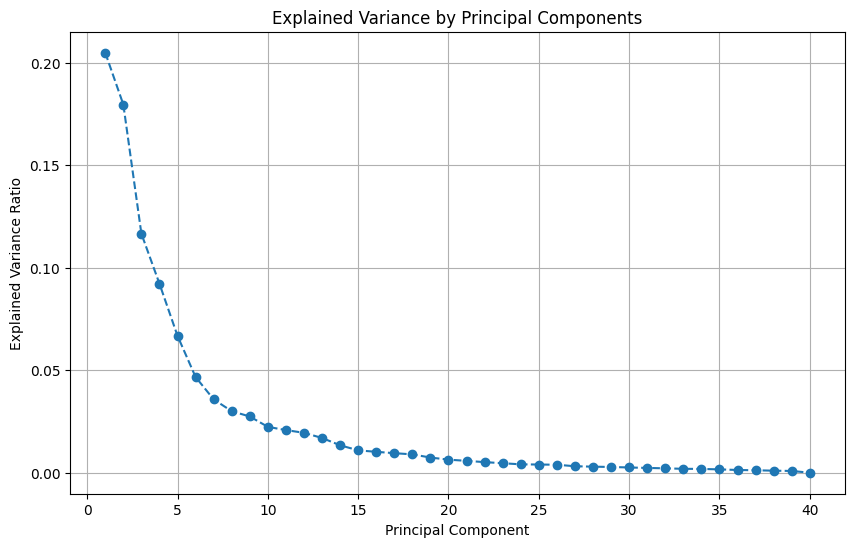

In [256]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Prepare the data for PCA
X = mouse_df.drop(['mouse', 'group', 'responder'], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

In [257]:
y.value_counts()

responder
0    22
1     8
Name: count, dtype: int64

Cross-validation scores: [0.875 0.875 0.875 0.875 0.875]
Average CV score: 0.875 (+/- 0.000)

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.93      0.92        30
        True       0.78      0.70      0.74        10

    accuracy                           0.88        40
   macro avg       0.84      0.82      0.83        40
weighted avg       0.87      0.88      0.87        40



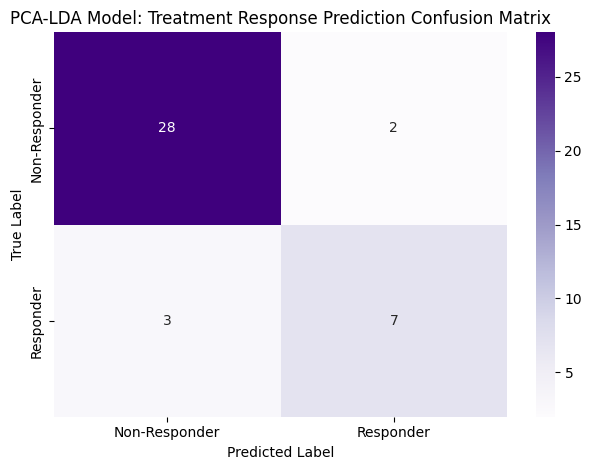

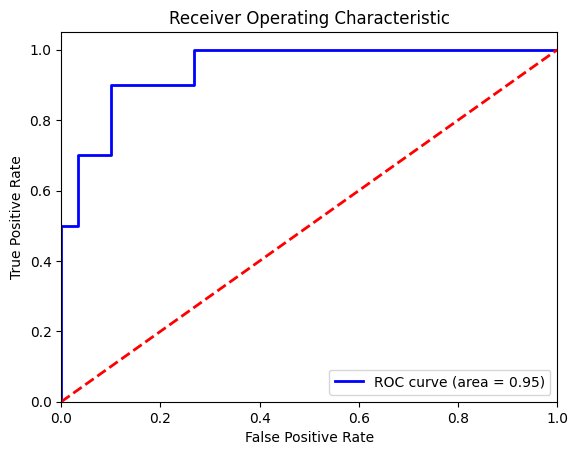

In [260]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Prepare X (features) and y (target) for modeling
# X = mouse_df.drop(['mouse', 'group', 'responder'], axis=1)
X = mouse_df.drop(['mouse', 'group', 'responder'], axis=1)
y = mouse_df['responder']
# y = mouse_df['responder'].astype(int)  # Convert boolean to int (0 and 1)

# Create a pipeline with PCA and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=14)),
    ('lda', LinearDiscriminantAnalysis()),
    # ('pca', PCA(n_components=15)),
    # ('lda', SVC(kernel='linear', probability=True)),
])

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv)

y_trues = []; y_preds = []; y_probs = []
for i, (train_ix, test_ix) in enumerate(cv.split(X)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Get predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Store true and predicted values
    y_trues.extend(y_test)
    y_preds.extend(y_pred)
    y_probs.extend(y_prob)

print("Cross-validation scores:", cv_scores)
print("Average CV score: {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))


# Print classification report
print("\nClassification Report:")
print(classification_report(y_trues, y_preds))

# Plot confusion matrix
plt.figure()
cm = confusion_matrix(y_trues, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('PCA-LDA Model: Treatment Response Prediction Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Responder', 'Responder'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Responder', 'Responder'])
plt.tight_layout()
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_trues, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Test Set Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.67      0.80         3
        True       0.50      1.00      0.67         1

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4



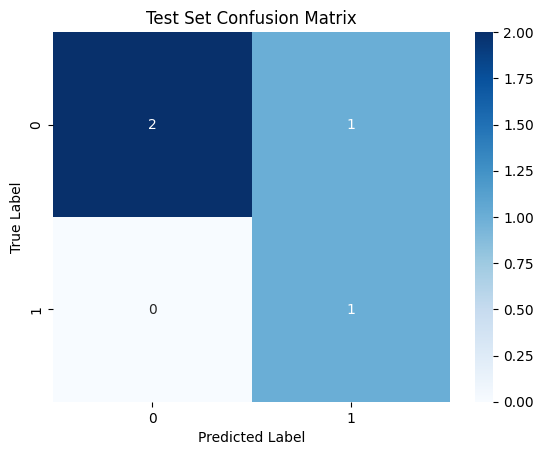

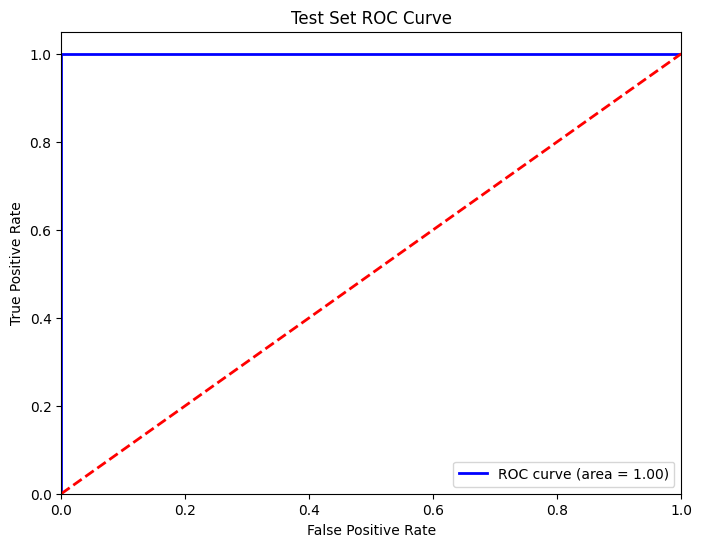

In [162]:
X_test = test_df.drop(['mouse', 'group', 'responder'], axis=1)
y_test = np.array(test_df['responder'], dtype=bool)

pipeline.fit(X, y)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred))
# Plot confusion matrix for test set
plt.figure()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC-AUC for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc='lower right')
plt.show()

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677/3053174230.py:84: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  torch_loo_scores.extend(np.array(pred_class == y_test).flatten())
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677/3053174230.py:85: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  torch_y_pred_all.extend(np.array(pred_class).flatten())
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677/3053174230.py:86: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  torch_y_true_all.extend(np.array(y_test).flatten())
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677


PyTorch Leave-One-Out Cross Validation Accuracy: 0.818


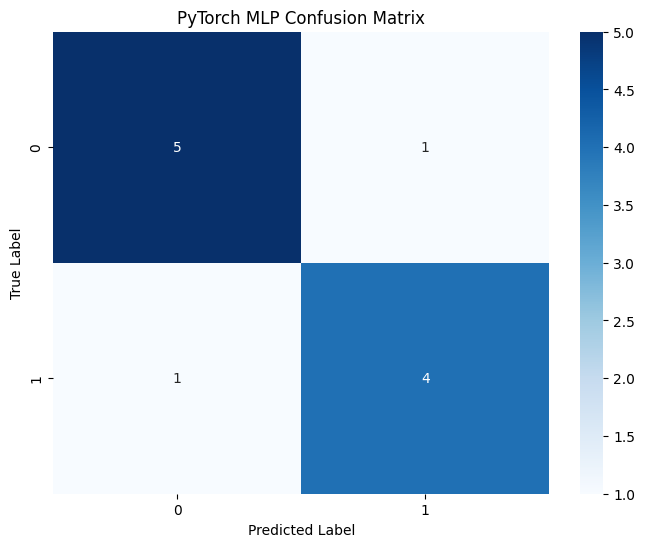


PyTorch Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83         6
         1.0       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11



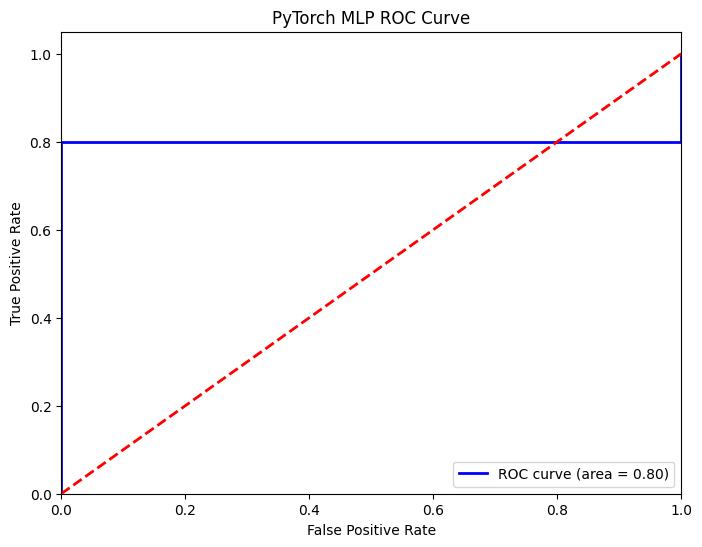

In [70]:
import torch

# Set random seed for reproducibility
torch.manual_seed(71)
torch.cuda.manual_seed(71)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

X = mouse_df.drop(['mouse', 'group', 'responder'], axis=1)
y = mouse_df['responder']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Select number of components that explain 95% of variance
n_components = 3

# Reduce dimensions to selected components
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

# Create a simple MLP classifier using PyTorch
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, 20)
        self.layer2 = torch.nn.Linear(20, 1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X_pca_final)
y_tensor = torch.FloatTensor(y.values.reshape(-1, 1))

# Perform Leave-One-Out Cross Validation with PyTorch
loo = KFold(n_splits=5, shuffle=True, random_state=42)
torch_loo_scores = []
torch_y_pred_all = []
torch_y_true_all = []
torch_y_probs_all = []

for train_idx, test_idx in loo.split(X_pca_final):
    # Split data
    X_train = X_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_train = y_tensor[train_idx]
    y_test = y_tensor[test_idx]
    
    # Initialize model and optimizer
    model = MLP(input_size=X_pca_final.shape[1])
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X_train)
        
        # Add L2 regularization
        l2_lambda = 0.01
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = criterion(outputs, y_train) + l2_lambda * l2_norm
        
        loss.backward()
        optimizer.step()
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        pred = model(X_test)
        pred_class = (pred >= 0.5).float()
        
    torch_loo_scores.extend(np.array(pred_class == y_test).flatten())
    torch_y_pred_all.extend(np.array(pred_class).flatten())
    torch_y_true_all.extend(np.array(y_test).flatten())
    torch_y_probs_all.extend(np.array(pred).flatten())
# Calculate and print results
torch_loo_accuracy = np.mean(torch_loo_scores)
print(f"\nPyTorch Leave-One-Out Cross Validation Accuracy: {torch_loo_accuracy:.3f}")

# Create confusion matrix
torch_cm = confusion_matrix(torch_y_true_all, torch_y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(torch_cm, annot=True, fmt='d', cmap='Blues')
plt.title('PyTorch MLP Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nPyTorch Classification Report:")
print(classification_report(torch_y_true_all, torch_y_pred_all))

# Plot ROC-AUC for PyTorch model
torch_fpr, torch_tpr, torch_thresholds = roc_curve(torch_y_true_all, torch_y_probs_all)
torch_roc_auc = auc(torch_fpr, torch_tpr)

plt.figure(figsize=(8, 6))
plt.plot(torch_fpr, torch_tpr, color='blue', lw=2, label=f'ROC curve (area = {torch_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PyTorch MLP ROC Curve')
plt.legend(loc='lower right')
plt.show()
